# Breast Cancer Wisconsin (Diagnostic) Dat set

Repository github "https://github.com/MauroMu/MML_BreastCancerDataset.git"


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

In [2]:
sns.set(palette='colorblind')
sns.set_style("darkgrid", {"axes.facecolor": ".96"})
sns.set_color_codes()

remove_outliers = False
whis = 2.7 # Fattore moltiplicativo interquartile range. Gestisce il numero di outliers da rimuovere

chi_test = True
p_max_chi2 = 0.05
pca_red = False # perform pca
lda_red = True # perform lda

if lda_red==True and pca_red==True:
    print('WARNING: Set pca_red or lda_red to False (they both are True)')
    See_Warning

## Data exploration

In [3]:
df = pd.read_csv('./wdbc.csv', sep=',', skiprows=0)
with pd.option_context('display.max_rows', 7, 'display.max_columns', 9):  # more options can be specified also
    display(df)
print('\nShape of the Data set: ', df.shape)

features = np.array(df)[:,2:]
print('\nShape of features vector: ', features.shape)

labels = np.array(df)[:,1]
#onehot encoding
labels[labels == 'B'] = 0
labels[labels == 'M'] = 1
print('\nLabels array sample (0-30): ', labels[0:30])
print('\nShape of labels vector: ', labels.shape)

#Define features dictionary
features_keys = list(df)
features_dictionary_byvalue = {v:k for k,v in zip(features_keys[2:],np.linspace(0,29,30, dtype='int'))}

features_dictionary_bykey = {k:v for k,v in zip(features_keys[2:],np.linspace(0,29,30, dtype='int'))}
print('\nFeatures dictionary by value:\n', features_dictionary_byvalue)
print('\nFeatures dictionary by key:\n', features_dictionary_bykey)

#Define labels dictionary
labels_dictionary = {0: 'Benign', 1: 'Malignant'}
print('\nLabels dictionary:\n', labels_dictionary)


# features: Features Numpy array
# labels: labels Numpy array
# features_dictionary: feature_key : associated column of "features array" (numpy_index)
# labels_dictionary: label_key : label_name

,id,diagnosis,radius_mean,texture_mean,...,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,...,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,...,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,...,0.4504,0.2430,0.3613,0.08758
...,...,...,...,...,...,...,...,...,...
566,926954,M,16.60,28.08,...,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,...,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,...,0.0000,0.0000,0.2871,0.07039



Shape of the Data set:  (569, 32)

Shape of features vector:  (569, 30)

Labels array sample (0-30):  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]

Shape of labels vector:  (569,)

Features dictionary by value:
 {0: 'radius_mean', 1: 'texture_mean', 2: 'perimeter_mean', 3: 'area_mean', 4: 'smoothness_mean', 5: 'compactness_mean', 6: 'concavity_mean', 7: 'concave_points_mean', 8: 'symmetry_mean', 9: 'fractal_dimension_mean', 10: 'radius_se', 11: 'texture_se', 12: 'perimeter_se', 13: 'area_se', 14: 'smoothness_se', 15: 'compactness_se', 16: 'concavity_se', 17: 'concave_points_se', 18: 'symmetry_se', 19: 'fractal_dimension_se', 20: 'radius_worst', 21: 'texture_worst', 22: 'perimeter_worst', 23: 'area_worst', 24: 'smoothness_worst', 25: 'compactness_worst', 26: 'concavity_worst', 27: 'concave_points_worst', 28: 'symmetry_worst', 29: 'fractal_dimension_worst'}

Features dictionary by key:
 {'radius_mean': 0, 'texture_mean': 1, 'perimeter_mean': 2, 'area_mean': 3, 'smoothne

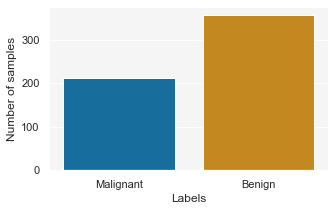

In [4]:
figdist, axdist = plt.subplots(figsize=(5,3))

distribution = pd.DataFrame({'Labels':('Benign', 'Malignant'), 
                             'Number of samples': (len(list(labels[labels==0])),len(list(labels[labels==1])))})
axdist = sns.barplot(x='Labels', y='Number of samples', 
            data=distribution, order = ['Malignant', 'Benign'])

### Some statistics

In [5]:
statistics = pd.DataFrame([features.mean(axis=0), features.min(axis=0), features.max(axis=0), 
                           features.std(axis=0, dtype= float), np.quantile(features, 0.25, axis=0),
                          np.quantile(features, 0.5, axis=0), np.quantile(features, 0.75, axis=0)])
statistics.columns = list(df)[2:]
statistics.rename(index = {0:'mean', 1:'min_value', 2:'max_value', 3:'std', 4 : '0.25_quantile', 
                           5 : '0.5_quantile', 6 : '0.75_quantile'}, inplace=True)

display(statistics[statistics.columns[0:8]])
# display(statistics[statistics.columns[8:16]])
# display(statistics[statistics.columns[16:24]])
# display(statistics[statistics.columns[24:]])

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919
min_value,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000
max_value,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200
std,3.520951,4.297255,24.277619,351.604754,0.014052,0.052766,0.079650,0.038769
0.25_quantile,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310
0.5_quantile,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500
0.75_quantile,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000


### Boxplots

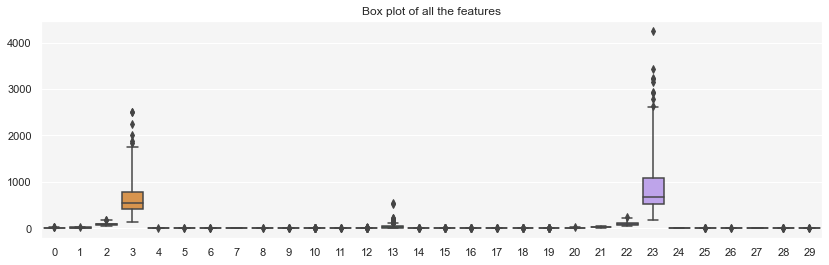

In [6]:
fig1, ax1 = plt.subplots(figsize=(14,4))
ax1.set_title('Box plot of all the features')
ax1 = sns.boxplot(data=features, whis = whis)
plt.show()

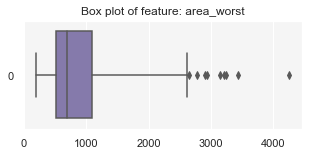

In [7]:
'''
Esempio singolo boxplot per mostrare presenza di outliers
Boxplot, estremi rettangolo: Primo e terzo quartile (quantili 0.25 e 0.75)
Boxplot, mediana: secondo quartile (quantile 0.5)
Boxplot, estremo superiore intervallo: trezo quartile + 1.5 * (Q3-Q2)/2
Boxplot, estremo inferiore intervallo: primo quartile - 1.5 * (Q2-Q1)/2
'''
i = 23 #Select the feature

fig2, ax2 = plt.subplots(figsize=(5,2))
ax2.set_title(f'Box plot of feature: {features_dictionary_byvalue[i]}')
ax1 = sns.boxplot(data=features[:,i], orient = 'h', color='m', whis = whis)
plt.show()

### Scatterplot and heatmap (Pearson's Correlation Coefficient)

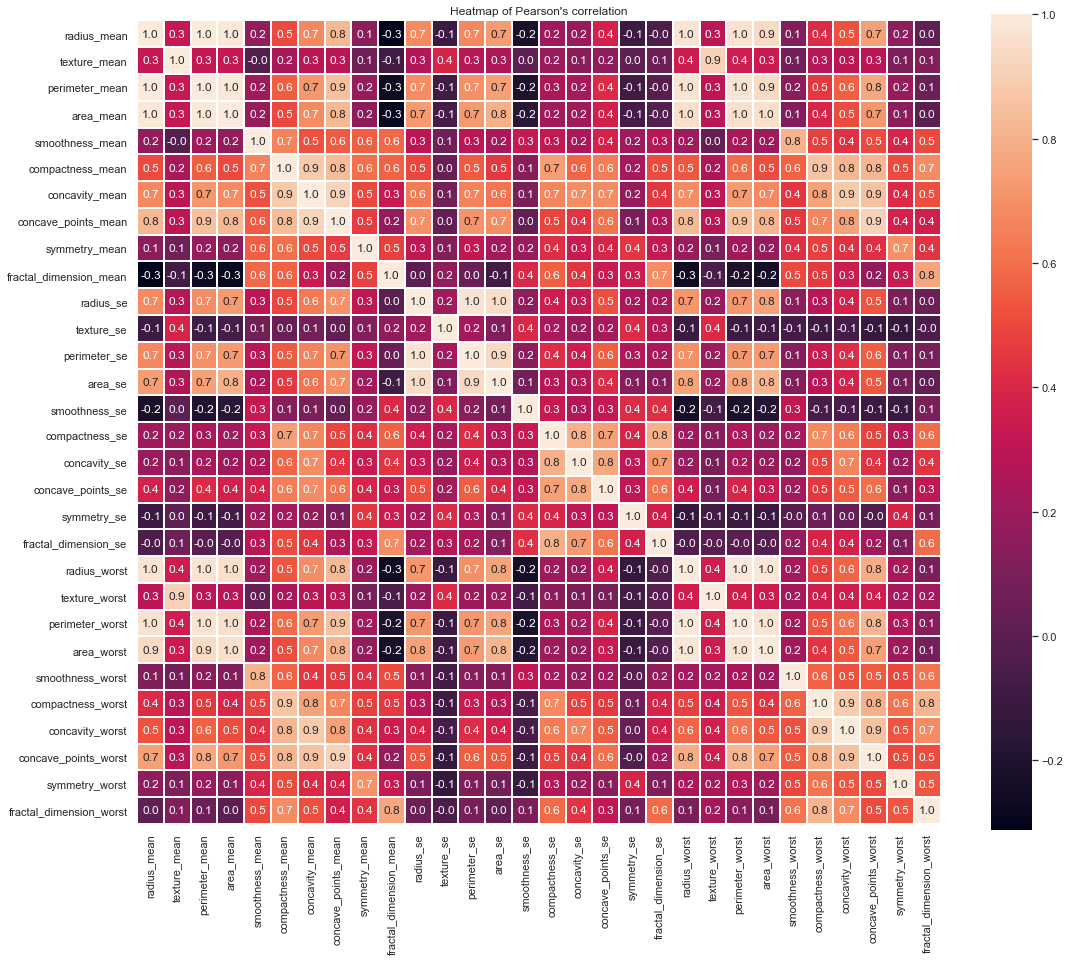

In [8]:
pc = df[df.columns[2:]].corr(method='pearson')
#display(pc)
fig3, ax3 = plt.subplots(figsize=(18,15))
ax3.set_title("Heatmap of Pearson's correlation")
ax3 = sns.heatmap(pc, linewidths =1, annot=True, fmt='.1f', square = True)

## Preprocessing

### Features Selection

The worst values are heavily correlated with the mean values. So we only select the ten values that are most linearly separable.
We want also to select the features that minimize the std error, so we include them in the maximization problem (see FeatureSelection function). However, the SE values are not usefull for the classification problem, so at the end we will remove them and we will have only ten features.

In [9]:
# Dataloader
def FeaturesSelection(features, labels, num_features = 10, dictionary = features_dictionary_byvalue):
    data = features #we don't need to normalize because the maximization problem is applied to "mean/variance"
    data_labels = labels
    
    medie = []
    varianze=[]
    std_err = np.array(np.mean(features[:,10:20],axis=0))
    std_err = np.hstack((std_err, std_err, std_err))
    print(std_err[5], std_err[25])

    for i in range (0,2):
        mask= data_labels == i
        varianze.append(list(np.var(data[mask], axis=0)))
        medie.append(list(np.mean(data[mask], axis=0)))
    
    print(varianze[0][5]+varianze[1][5], varianze[0][25]+varianze[1][25])
    print((medie[0][5]-medie[1][5])**2, (medie[0][25]-medie[1][25])**2)

    decision_vector=[]

    # To maximize the difference between the mean values of the two classes 
    # and to minimize the variance and the standard error

    for i, el in enumerate(medie[0]):
        val = ((medie[0][i]- medie[1][i])**2)/(varianze[0][i]+varianze[1][i]+(std_err[i])**2)
        decision_vector.append(val)
        

    indices_bestFeatures = np.argsort(decision_vector) # sort in ascending order
    values_dict = {k:v for k,v in zip(indices_bestFeatures, np.sort(decision_vector))}
    
    num = indices_bestFeatures.shape[0]   
    lista = []
    for i in range(1, num + 1):
        lista.append(indices_bestFeatures[-i])
    
    selected_features = []
    feat_names = []
    selected_features_separability = []
    warn = list(np.linspace(10,19,10, dtype=int)) # Removing the SE values
    
    for i in lista:
        if i not in warn:
            selected_features.append(i)
            selected_features_separability.append(values_dict[i])
            feat_names.append(dictionary[i])
            warn.append(i)
            warn.append(i+20)
            warn.append(i-20)
            if(len(selected_features) == num_features):
                break
                
    return selected_features, feat_names, selected_features_separability

In [10]:
f_values, f_names, f_separability = FeaturesSelection(features, labels, num_features=10)
print(f_values,'\n\n', f_names, '\n\n', f_separability)

dict_score = {k:v for k,v in zip(f_names, f_separability)}
print(dict_score)


#Senza includere std error [27, 22, 20, 23, 6, 5, 21, 24, 28, 29] [27, 22, 20, 7, 2, 0, 23, 3, 6, 26, 25, 5, 21, 1, 24, 28, 4, 29, 8, 9] 
#Includendo std error [27, 22, 20, 23, 6, 25, 21, 24, 28, 29]  [27, 22, 7, 20, 2, 0, 23, 6, 3, 26, 5, 25, 21, 1, 24, 28, 4, 8, 29, 9]

0.025478138840070306 0.025478138840070306
0.004036770067165981 0.03736304229119697
0.004238421594343708 0.0369222199943707
[27, 22, 20, 23, 6, 25, 21, 24, 28, 29] 

 ['concave_points_worst', 'perimeter_worst', 'radius_worst', 'area_worst', 'concavity_mean', 'compactness_worst', 'texture_worst', 'smoothness_worst', 'symmetry_worst', 'fractal_dimension_worst'] 

 [3.271843789577215, 2.8032455834591414, 2.691871653730112, 1.9402499644452924, 1.5481463518968541, 0.9713260876584693, 0.5522760106390874, 0.42749365686263285, 0.36733023517481284, 0.2191462154005804]
{'concave_points_worst': 3.271843789577215, 'perimeter_worst': 2.8032455834591414, 'radius_worst': 2.691871653730112, 'area_worst': 1.9402499644452924, 'concavity_mean': 1.5481463518968541, 'compactness_worst': 0.9713260876584693, 'texture_worst': 0.5522760106390874, 'smoothness_worst': 0.42749365686263285, 'symmetry_worst': 0.36733023517481284, 'fractal_dimension_worst': 0.2191462154005804}


In [11]:
print(0.0042/(0.0040+0.025))
print(0.0369/(0.037+0.025))

0.14482758620689654
0.5951612903225807


In [12]:
reduced_df = pd.DataFrame()

for el in f_values:
    reduced_df[features_dictionary_byvalue[el]] = df[features_dictionary_byvalue[el]]
            
display(reduced_df)

,concave_points_worst,perimeter_worst,radius_worst,area_worst,concavity_mean,compactness_worst,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,0.2654,184.60,25.380,2019.0,0.30010,0.66560,17.33,0.16220,0.4601,0.11890
1,0.1860,158.80,24.990,1956.0,0.08690,0.18660,23.41,0.12380,0.2750,0.08902
2,0.2430,152.50,23.570,1709.0,0.19740,0.42450,25.53,0.14440,0.3613,0.08758
3,0.2575,98.87,14.910,567.7,0.24140,0.86630,26.50,0.20980,0.6638,0.17300
4,0.1625,152.20,22.540,1575.0,0.19800,0.20500,16.67,0.13740,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...
564,0.2216,166.10,25.450,2027.0,0.24390,0.21130,26.40,0.14100,0.2060,0.07115
565,0.1628,155.00,23.690,1731.0,0.14400,0.19220,38.25,0.11660,0.2572,0.06637
566,0.1418,126.70,18.980,1124.0,0.09251,0.30940,34.12,0.11390,0.2218,0.07820
567,0.2650,184.60,25.740,1821.0,0.35140,0.86810,39.42,0.16500,0.4087,0.12400


### Heatmap - Pearson's Correlation of the reduced dataset

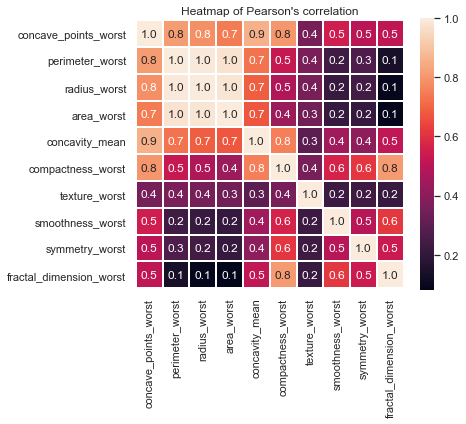

In [13]:
pc_reduced = reduced_df.corr(method='pearson')
#display(pc_reduced)
fig3, ax3 = plt.subplots(figsize=(6,5))
ax3.set_title("Heatmap of Pearson's correlation")
ax3 = sns.heatmap(pc_reduced, linewidths =1, annot=True, fmt='.1f', square = True)

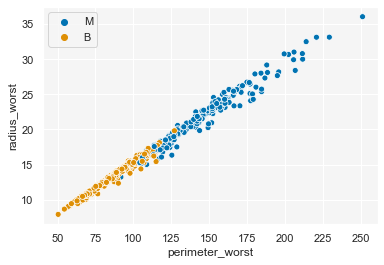

In [14]:
legend = np.array(labels).astype('str')
legend[labels == 0] = labels_dictionary[0]
legend[labels == 1] = labels_dictionary[1]

i=22
j=20
data = pd.DataFrame([list(features[:,i])].append(list(features[:,j])))
ax = sns.scatterplot(x=features_dictionary_byvalue[i], y=features_dictionary_byvalue[j], data=df, hue=legend)

Sono ancora presenti delle coppie con correlazione unitaria, ovvero che non aggiungono alcuna informazione poiché esprimibili come combinazione lineare delle altre.
Un esempio sono il raggio, il perimetro e l'area. Supponendo di avere una circonferenza "perimetro = 2*pi*r = cost * r". 
Tra di queste, quindi, ne seleziono soltanto una che contiene l'informazione di tutte. 
In questo caso è logico suppore che il perimetro sia la misura più esplicativa, ma è neccessario stabilire un criterio per ridurre automaticamente il numero di features.

Le feature attualmente selezionate sono:
[27, 22, 20, 23, 6, 25, 21, 24, 28, 29]
Sono distribuite in ordine decrescente per separabilità (vedere the FeaturesSelection function).
Considerando perimetro, raggio e area (rispettivamente features 22, 20, 23), il perimetro è quella che presenta una migliore separabilità tra le classi, quindi quella da selezionare.

Criterio:
Seleziono le features seguendo l'ordine del vettore attuale, escludendo quelle che hanno correlazione maggiore di 0.99 con quelle già selezionate.

### Final data set and heatmap

In [15]:
final_df = pd.DataFrame()

f_final_values = []
for el in f_values:
    flag=0
    for count in f_final_values:
        if pc.iloc[count, el] > 0.9:
            flag = 1
    if flag == 0:
        final_df[features_dictionary_byvalue[el]] = df[features_dictionary_byvalue[el]]
        f_final_values.append(el)
            
display(final_df)

#define final dictionary
features_keys = list(final_df)
final_dict_byval = {v:k for k,v in zip(list(final_df),np.linspace(0,len(list(final_df)),
                                                                  len(list(final_df))+1, dtype='int'))}

,concave_points_worst,perimeter_worst,concavity_mean,compactness_worst,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,0.2654,184.60,0.30010,0.66560,17.33,0.16220,0.4601,0.11890
1,0.1860,158.80,0.08690,0.18660,23.41,0.12380,0.2750,0.08902
2,0.2430,152.50,0.19740,0.42450,25.53,0.14440,0.3613,0.08758
3,0.2575,98.87,0.24140,0.86630,26.50,0.20980,0.6638,0.17300
4,0.1625,152.20,0.19800,0.20500,16.67,0.13740,0.2364,0.07678
...,...,...,...,...,...,...,...,...
564,0.2216,166.10,0.24390,0.21130,26.40,0.14100,0.2060,0.07115
565,0.1628,155.00,0.14400,0.19220,38.25,0.11660,0.2572,0.06637
566,0.1418,126.70,0.09251,0.30940,34.12,0.11390,0.2218,0.07820
567,0.2650,184.60,0.35140,0.86810,39.42,0.16500,0.4087,0.12400


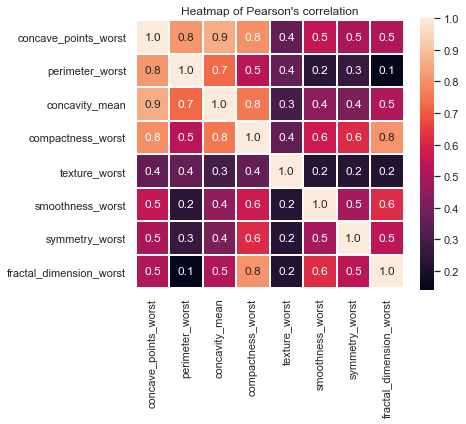

In [16]:
pc_final = final_df.corr(method='pearson')
#display(pc_reduced)
fig3, ax3 = plt.subplots(figsize=(6,5))
ax3.set_title("Heatmap of Pearson's correlation")
ax3 = sns.heatmap(pc_final, linewidths =1, annot=True, fmt='.1f', square = True)

In [17]:
x= np.linspace(0,100,100)
df_test = pd.DataFrame({'x': x, 'y': x**2, 'z': 2*3.14*x})
print(df_test.corr(method='pearson'))

          x         y         z
x  1.000000  0.967644  1.000000
y  0.967644  1.000000  0.967644
z  1.000000  0.967644  1.000000


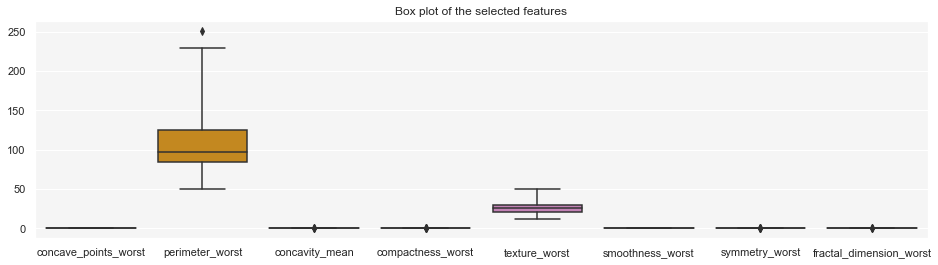

In [18]:
fig1, ax1 = plt.subplots(figsize=(16,4))
ax1.set_title('Box plot of the selected features')
ax1 = sns.boxplot(data=final_df, whis = whis)
plt.show()

It is clear that we need to normilize our data

In [19]:
scaler = StandardScaler()

norm_df = pd.DataFrame(scaler.fit_transform(final_df))
norm_df.columns = list(final_df)
display(norm_df)

,concave_points_worst,perimeter_worst,concavity_mean,compactness_worst,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,2.296076,2.303601,2.652874,2.616665,-1.359293,1.307686,2.750622,1.937015
1,1.087084,1.535126,-0.023846,-0.430444,-0.369203,-0.375612,-0.243890,0.281190
2,1.955000,1.347475,1.363478,1.082932,-0.023974,0.527407,1.152255,0.201391
3,2.175786,-0.249939,1.915897,3.893397,0.133984,3.394275,6.046041,4.935010
4,0.729259,1.338539,1.371011,-0.313395,-1.466770,0.220556,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...
564,1.629151,1.752563,1.947285,-0.273318,0.117700,0.378365,-1.360158,-0.709091
565,0.733827,1.421940,0.693043,-0.394820,2.047399,-0.691230,-0.531855,-0.973978
566,0.414069,0.579001,0.046588,0.350735,1.374854,-0.809587,-1.104549,-0.318409
567,2.289985,2.303601,3.296944,3.904848,2.237926,1.430427,1.919083,2.219635


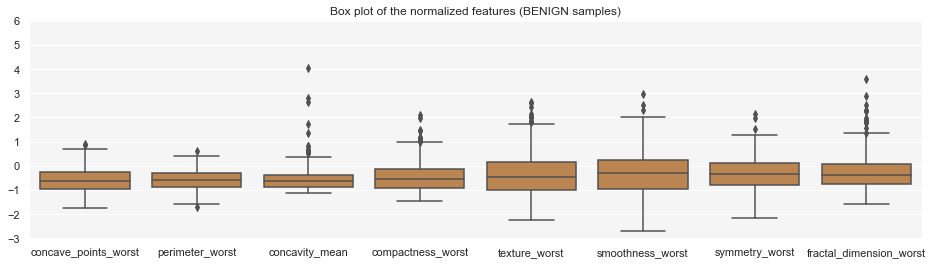

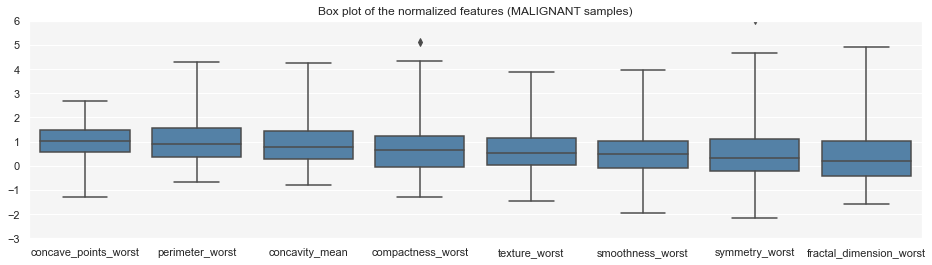

'Malignant'

In [20]:
fig1, ax1 = plt.subplots(figsize=(16,4))
ax1.set_title('Box plot of the normalized features (BENIGN samples)')
ax1 = sns.boxplot(data=norm_df[labels==0], whis = 1.5, color='peru')
ax1.set_ylim(-3,6)
plt.show()

fig1, ax1 = plt.subplots(figsize=(16,4))
ax1.set_title('Box plot of the normalized features (MALIGNANT samples)')
ax1 = sns.boxplot(data=norm_df[labels==1], whis = 2.7, color='steelblue')
ax1.set_ylim(-3,6)
plt.show()

labels_dictionary[1]

In [21]:
def PlotDist(labels, final_labels):
    
    figdist, axdist = plt.subplots(1,2,figsize=(10,5))
    distribution = pd.DataFrame({'Labels':('Benign', 'Malignant'), 
                                 'Number of samples': (len(list(labels[labels==0])),len(list(labels[labels==1])))})

    sns.barplot(x='Labels', y='Number of samples', ax=axdist[0], 
                data=distribution, order = ['Malignant', 'Benign'])

    distribution = pd.DataFrame({'Labels':('Benign', 'Malignant'), 
                                 'Number of samples': (len(list(final_labels[final_labels==0])),
                                                       len(list(final_labels[final_labels==1])))})

    sns.barplot(x='Labels', y='Number of samples', ax=axdist[1], data=distribution, order = ['Malignant', 'Benign'])

    axdist[0].set_ylim(0,370)
    axdist[0].set_title('Original Distribution')
    axdist[1].set_ylim(0,370)
    axdist[1].set_title('Distribution removing outliers (with IQR)')

    plt.show()

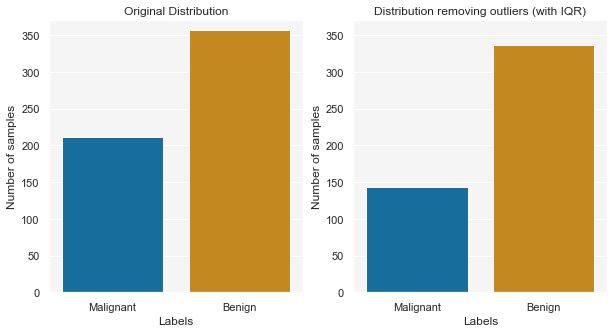

In [22]:
norm_df_noliars = norm_df.copy()
norm_df_noliars['labels'] = pd.DataFrame(labels)
for i in range(len(list(norm_df_noliars))-1):
    q1 = np.quantile(np.array(norm_df_noliars)[:,i], 0.25)
    q2 = np.quantile(np.array(norm_df_noliars)[:,i], 0.50)
    q3 = np.quantile(np.array(norm_df_noliars)[:,i], 0.75)

    min_th = q1 - (q2-q1)*whis
    max_th = q3 + (q3-q2)*whis

    norm_df_noliars = norm_df_noliars[(norm_df_noliars.iloc[:,i] < max_th) & (norm_df_noliars.iloc[:,i] > min_th)]

final_labels = np.array(norm_df_noliars['labels'])
final_labels = final_labels.astype('int')
norm_df_noliars = norm_df_noliars.drop(columns='labels')

PlotDist(labels=labels, final_labels=final_labels)

In [23]:
# def RemoveOutliers(norm_df_noliars = norm_df.copy(), whis=whis):
#     norm_df_noliars['labels'] = pd.DataFrame(labels)
#     for lab in [0,1]:
#         norm_df_lab = norm_df_noliars[norm_df_noliars['labels'] == lab]
#         norm_df_lab_min = norm_df_noliars.mask(norm_df_noliars['labels']!=lab, 10e6)
#         norm_df_lab_max = norm_df_noliars.mask(norm_df_noliars['labels']!=lab, -10e6)

#         for i in range(len(list(norm_df_noliars))-1):
#             q1 = np.quantile(np.array(norm_df_lab)[:,i], 0.25)
#             q2 = np.quantile(np.array(norm_df_lab)[:,i], 0.50)
#             q3 = np.quantile(np.array(norm_df_lab)[:,i], 0.75)

#             min_th = q1 - (q2-q1)*whis
#             max_th = q3 + (q3-q2)*whis

#             norm_df_noliars = norm_df_noliars[(norm_df_lab_max.iloc[:,i] < max_th) & (norm_df_lab_min.iloc[:,i] > min_th)]

#     final_labels = np.array(norm_df_noliars['labels'])
#     final_labels = final_labels.astype('int')
#     norm_df_noliars = norm_df_noliars.drop(columns='labels')


# PlotDist()
        
# # if remove_outliers:
# if 0:
#     norm_df, final_labels = RemoveOutliers()
#     remove_outliers = False
# else:
#     final_labels = labels
#     final_labels = final_labels.astype('int')
#     labels = labels.astype('int')
    

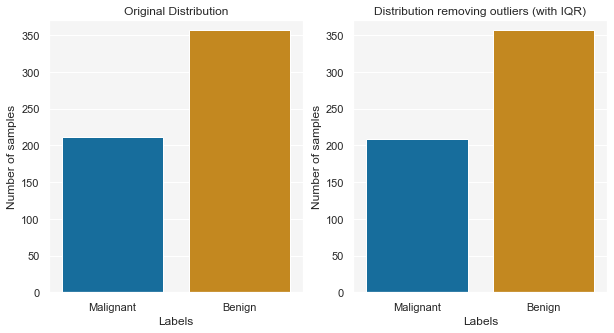

In [24]:
outliers = [38, 297, 461]

norm_df['labels'] = pd.DataFrame(labels)
norm_df = norm_df.drop(outliers)

final_labels = np.array(norm_df['labels'])
final_labels = final_labels.astype('int')
norm_df = norm_df.drop(columns='labels')

PlotDist(labels=labels, final_labels=final_labels)

### Display probability distribution

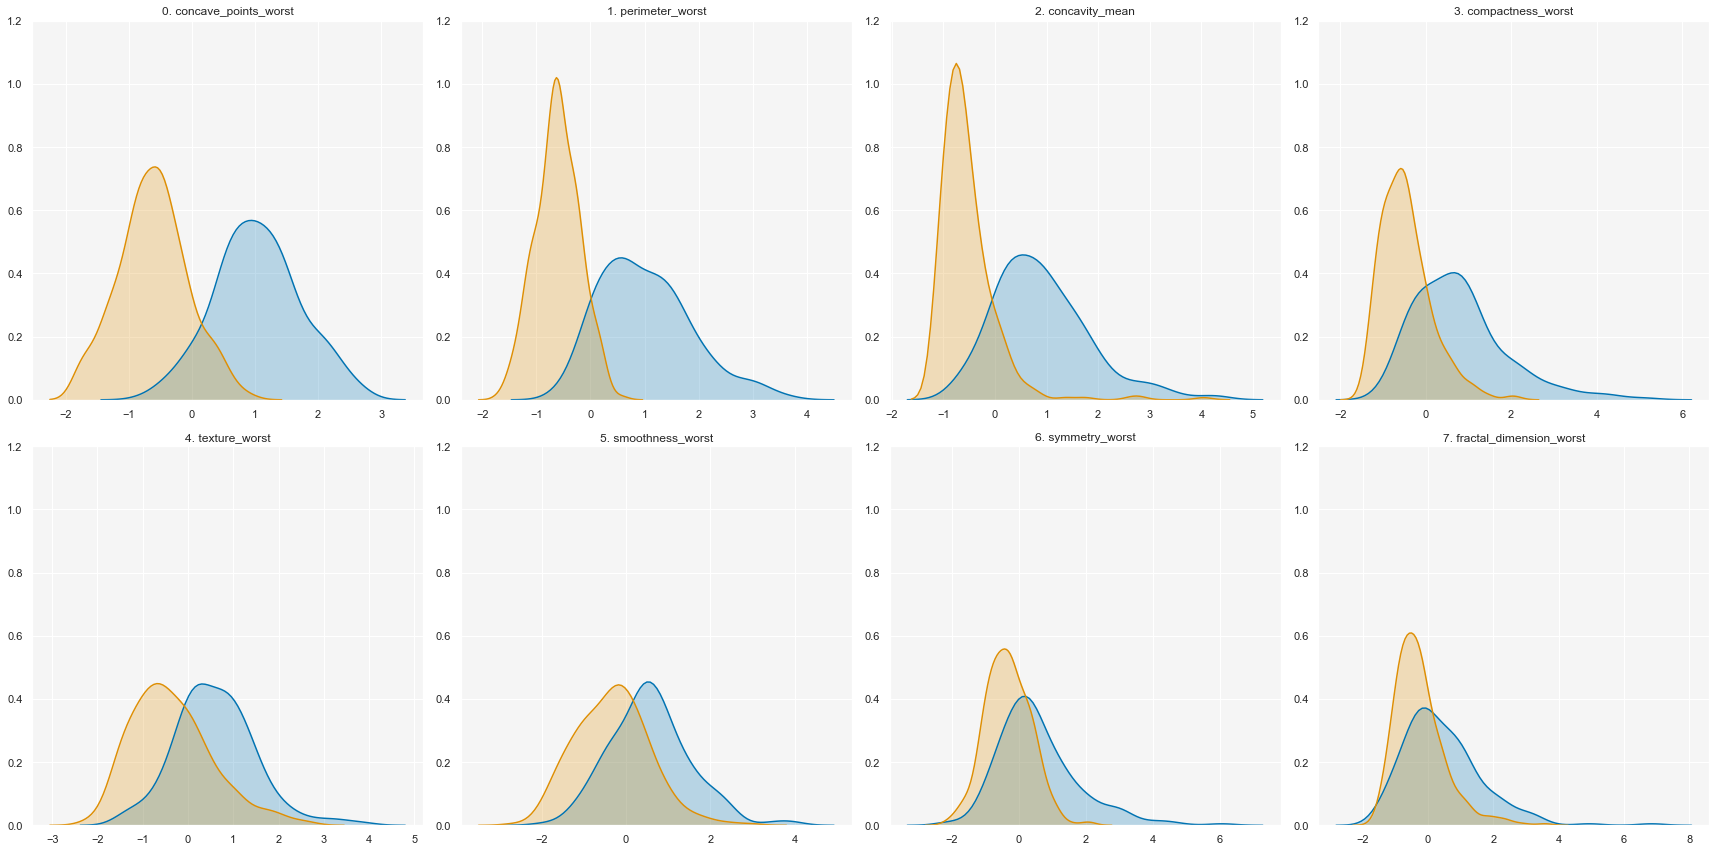

In [25]:
import math

rows=2
cols=4

fig, ax = plt.subplots(rows,cols,figsize=(6*cols,6*rows))

r=0
c=0
for j,feat in enumerate(list(norm_df)):
    for lab in [1,0]:
        dist = np.array(norm_df[final_labels == lab])
        sns.kdeplot(dist[:,j], ax = ax[r,c], shade=True)
        ax[r,c].set_title(f"{j}. {feat}")
        ax[r,c].set_ylim(0,1.2)
        #ax[r,c].legend(('Benign', 'Malignant'))
    c+=1
    if c==4:
        c=0
        r+=1
        
plt.tight_layout()
plt.show()

### PCA - Explained variance and reduction (if pca_red == True)

0.830963250043449


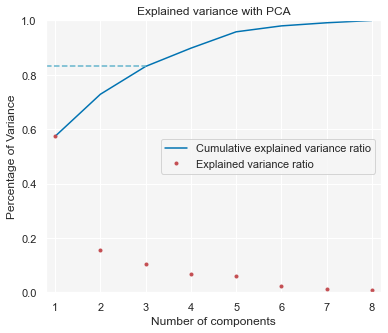

In [26]:
n_c = len(list(norm_df))
pca = PCA(n_components= n_c) 
pca.fit(norm_df)
fig, ax = plt.subplots(figsize=(6,5))
plt.xlabel('Number of components')
plt.ylabel('Percentage of Variance')
plt.title('Explained variance with PCA')

ax.plot(np.linspace(1,n_c,n_c), np.cumsum(pca.explained_variance_ratio_))
ax.plot(np.linspace(1,n_c,n_c), pca.explained_variance_ratio_, marker = '.', linestyle='', color='r')
# ax.plot([0.8,6.2], [0.9,0.9], c='y')
ax.plot([0.8,3], [np.cumsum(pca.explained_variance_ratio_)[2], 
                  np.cumsum(pca.explained_variance_ratio_)[2]], c='c', linestyle='--')

print(np.cumsum(pca.explained_variance_ratio_)[2])
ax.legend(('Cumulative explained variance ratio', 'Explained variance ratio', 'Threshold (0.9)'), loc=7)
ax.legend(('Cumulative explained variance ratio', 'Explained variance ratio'), loc=7)
ax.set_ylim(0,1)
ax.set_xlim(0.8, n_c + 0.2)
plt.show()


In [54]:
n_components_PCA = 5

pca = PCA(n_components = n_components_PCA)  #n_components = 3 - about 90% of explained variance
pca.fit(norm_df)
df_PCA = pca.fit_transform(norm_df)
c=0

# for j in range(df_PCA.shape[1]):
#     for i in range(j+1, df_PCA.shape[1]):
#         if i != j:
#             fig, ax = plt.subplots(figsize=(3,3))
#             sns.scatterplot(df_PCA[:,j], df_PCA[:,i], ax = ax, 
#                             hue = [(lambda x: 'Benign' if x==0 else 'Malignant')(x) for x in final_labels], 
#                             legend='full')

#             ax.set_title(f"Principal Components {j} and {i}")
#             ax.set_xlabel(f'PC {j}')
#             ax.set_ylabel(f'PC {i}')
#             #ax[c].legend(('Benign', 'Malignant'))
#             c+=1
#             plt.show()

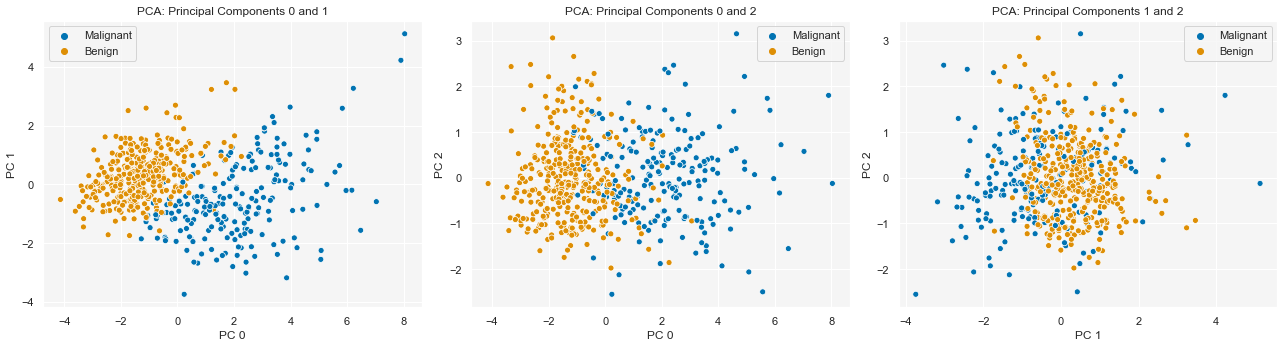

In [28]:
# Grafici PCA n_components = 3

pca = PCA(n_components = 3)  #n_components = 3 - about 83% of explained variance
pca.fit(norm_df)
df_PCA = pca.fit_transform(norm_df)

fig, ax = plt.subplots(1,int((df_PCA.shape[1]*(df_PCA.shape[1]-1)/2)),figsize=(18,5))
plot_labels = final_labels
c=0
for j in range(df_PCA.shape[1]):
    for i in range(j+1, df_PCA.shape[1]):
        if i != j:
            sns.scatterplot(df_PCA[:,j], df_PCA[:,i], ax = ax[c], 
                            hue = [(lambda x: 'Benign' if x==0 else 'Malignant')(x) for x in final_labels], 
                            legend='full')

            ax[c].set_title(f"PCA: Principal Components {j} and {i}")
            ax[c].set_xlabel(f'PC {j}')
            ax[c].set_ylabel(f'PC {i}')
            #ax[c].legend(('Benign', 'Malignant'))
            c+=1

plt.tight_layout()
plt.show()

[0 1]


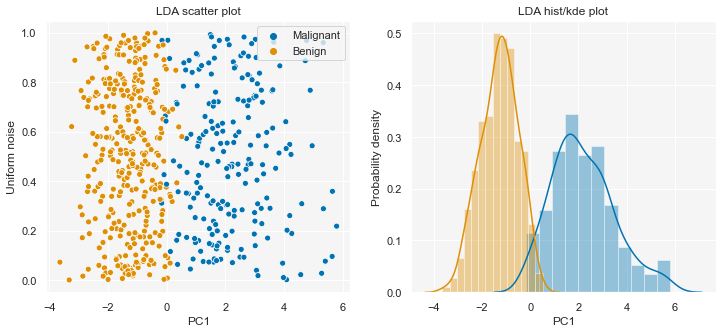

In [29]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(norm_df, final_labels)

df_LDA = lda.transform(norm_df)
df_LDA = df_LDA.reshape(df_LDA.shape[1], df_LDA.shape[0])

#df_LDA = StandardScaler().fit_transform(df_LDA)



fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(df_LDA[0], np.random.rand(len(final_labels)), ax=ax[0], 
                hue = [(lambda x: 'Benign' if x==0 else 'Malignant')(x) for x in final_labels], 
                legend='full')

ax[0].set_title(f"LDA scatter plot")
ax[0].set_xlabel(f'PC1')
ax[0].set_ylabel(f'Uniform noise')

ax[1].set_title(f"LDA hist/kde plot")
ax[1].set_xlabel(f'PC1')
ax[1].set_ylabel(f'Probability density')

sns.distplot(df_LDA[0][final_labels==1], ax=ax[1])
sns.distplot(df_LDA[0][final_labels==0], ax=ax[1])

print(lda.classes_)

plt.show()

# Classification Task

1) Start again from the original dataset (but with only the selected features)

2) Split the original dataset into Training and Test set

3) Fit the scaler on the training set and transform training and test set

4) Remove outliers from the training set

5) Create two copies of the training set:
   5.1) Copy n.1: Aplly PCA with n_components = 5 and perform SVD using GridsearchCV (Uppurbound)
   5.2) Copy n.2: Aplly LDA and perform LogisticRegression using GridsearchCV (Uppurbound)
   
6) Plot the validation scores, test the models and show the differences

In [30]:
display(norm_df)

,concave_points_worst,perimeter_worst,concavity_mean,compactness_worst,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,2.296076,2.303601,2.652874,2.616665,-1.359293,1.307686,2.750622,1.937015
1,1.087084,1.535126,-0.023846,-0.430444,-0.369203,-0.375612,-0.243890,0.281190
2,1.955000,1.347475,1.363478,1.082932,-0.023974,0.527407,1.152255,0.201391
3,2.175786,-0.249939,1.915897,3.893397,0.133984,3.394275,6.046041,4.935010
4,0.729259,1.338539,1.371011,-0.313395,-1.466770,0.220556,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...
564,1.629151,1.752563,1.947285,-0.273318,0.117700,0.378365,-1.360158,-0.709091
565,0.733827,1.421940,0.693043,-0.394820,2.047399,-0.691230,-0.531855,-0.973978
566,0.414069,0.579001,0.046588,0.350735,1.374854,-0.809587,-1.104549,-0.318409
567,2.289985,2.303601,3.296944,3.904848,2.237926,1.430427,1.919083,2.219635


## Train-Test Split

In [31]:
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(norm_df), final_labels, 
                                                            test_size=0.25, stratify = final_labels, random_state=42)


# proportion 75 25

In [32]:
X_train_val_svm = X_train_val.copy()
X_train_val_logit = X_train_val.copy()

In [33]:
def PCA_reduction(X_train, X_test, n_components=5):
    pca = PCA(n_components = 5)  
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    return X_train, X_test

In [34]:
def LDA_reduction(X_train, X_test, y_train):
    lda = LinearDiscriminantAnalysis() 
    lda.fit(X_train, y_train)
    X_train = lda.transform(X_train)
    X_test = lda.transform(X_test)
    
    return X_train, X_test

In [35]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

def plot_validation_curve(X,y,params, log_scale = True, y_min=0.0, y_max=1.1):
    param_range = params['param_range']
    param_name = params['param_name']
    
    train_scores, test_scores = validation_curve(
        params['classifier'], X, y, param_name=param_name, param_range=param_range,
        scoring="accuracy", n_jobs=1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if param_name == 'class_weight':
        param_range = np.linspace(0,len(param_range)-1, len(param_range))

    plt.title("Validation Curve " + params['name_classifier'] )
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(y_min, y_max)
    lw = 2
    plt.plot(param_range, train_scores_mean,'-o', label="Training score",
                 color="navy", lw=lw)
#     plt.plot(param_range, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2,
#                      color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,'-o', label="Cross-validation score",
                 color="peru", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="peru", lw=lw)
    plt.legend(loc="best")
    
    if log_scale:
        plt.xscale('log')
        
    plt.show()
    print(test_scores_mean)

## Linear SVM

In [36]:
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import LinearSVC


pca_svm = True

if pca_svm:
    X_train_val_svm, X_test_svm = PCA_reduction(X_train_val_svm, X_test, n_components=2)
    print('PCA')
else:
    X_test_svm = X_test.copy()

PCA


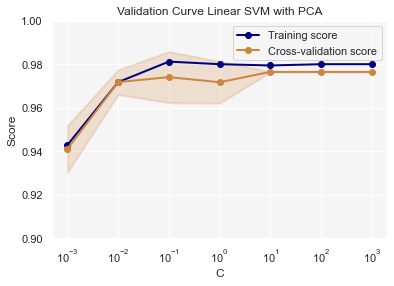

[0.9410084  0.97170868 0.9740056  0.97165266 0.97641457 0.97641457
 0.97641457]


In [37]:
params = {
    'classifier': LinearSVC(max_iter=800000),
    'param_name':'C',
    'param_range':[0.001,0.01,0.1,1,10,100,1000],
    'name_classifier':'Linear SVM with PCA'
}

plot_validation_curve(X_train_val_svm, y_train_val, params, y_min=0.9, y_max=1.0)

In [158]:
print((97.1+98.5)/2)

97.8


0.971830985915493 



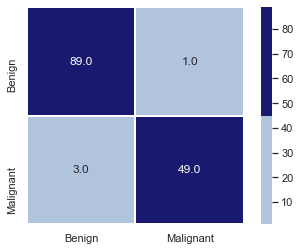

In [154]:
clf = LinearSVC(C=10, max_iter=8000)
clf.fit(X_train_val_svm, y_train_val)
y_pred = clf.predict(X_test_svm)

a =accuracy_score(y_test, y_pred)
print(a,'\n')


from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred, labels=(0, 1))
ax3 = sns.heatmap(c_matrix, linewidths =1, annot=True, fmt='.1f', square = True, cmap=['lightsteelblue', 'midnightblue'], 
                  xticklabels = ('Benign', 'Malignant'), yticklabels=('Benign','Malignant'))

## Non-linear SVM (RBF kernel)

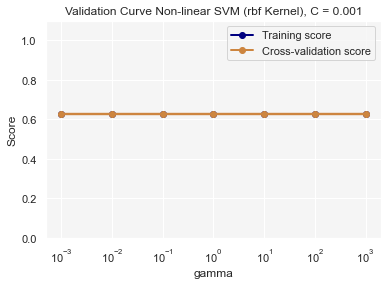

[0.62971989 0.62971989 0.62971989 0.62971989 0.62971989 0.62971989
 0.62971989]


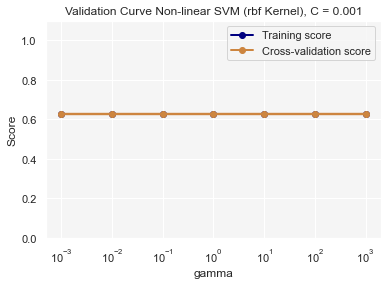

[0.62971989 0.62971989 0.62971989 0.62971989 0.62971989 0.62971989
 0.62971989]


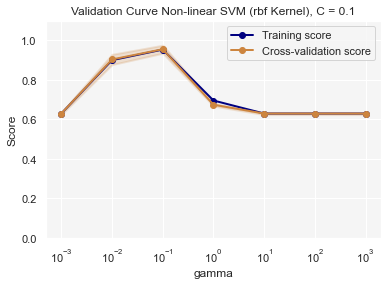

[0.62971989 0.90336134 0.95521008 0.6745098  0.62971989 0.62971989
 0.62971989]


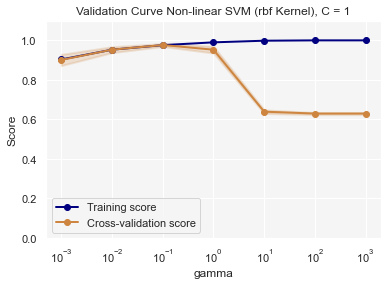

[0.90098039 0.95282913 0.97641457 0.95277311 0.63915966 0.62971989
 0.62971989]


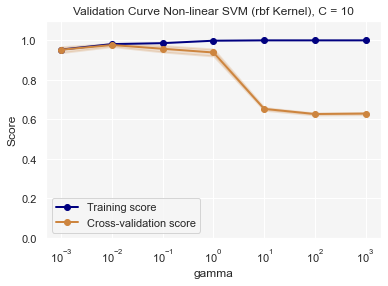

[0.95282913 0.97638655 0.95747899 0.93862745 0.65327731 0.62736695
 0.62971989]


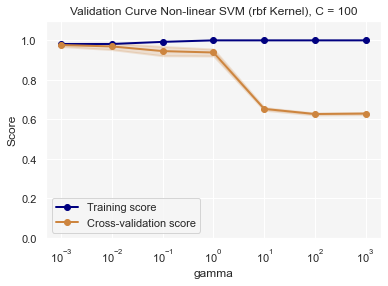

[0.97638655 0.96927171 0.94565826 0.93862745 0.65327731 0.62736695
 0.62971989]


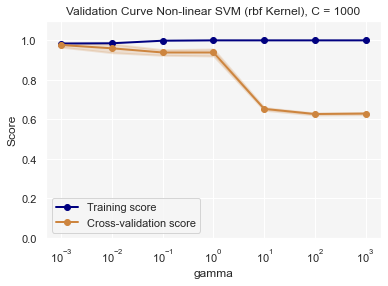

[0.97638655 0.95980392 0.93862745 0.93862745 0.65327731 0.62736695
 0.62971989]


In [159]:
for C in [0.001, 0.001,0.1,1,10,100,1000]:
    params = {
        'classifier': SVC(C=C, max_iter=3000, kernel='rbf'),
        'param_name':'gamma',
        'param_range':[0.001,0.01,0.1,1,10,100,1000],
        'name_classifier':f'Non-linear SVM (rbf Kernel), C = {C}'
    }

    plot_validation_curve(X_train_val_svm, y_train_val, params, y_min=0, y_max=1.1)

0.971830985915493


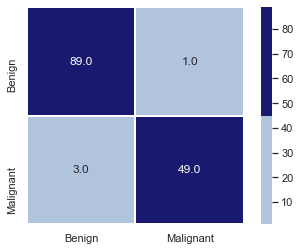

In [155]:
clf = SVC(gamma=0.1, C=1, max_iter=3000, kernel='rbf')
clf.fit(X_train_val_svm, y_train_val)
y_pred = clf.predict(X_test_svm)

a =accuracy_score(y_test, y_pred)
print(a)

from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred, labels=(0, 1))
ax3 = sns.heatmap(c_matrix, linewidths =1, annot=True, fmt='.1f', square = True, cmap=['lightsteelblue', 'midnightblue'], 
                  xticklabels = ('Benign', 'Malignant'), yticklabels=('Benign','Malignant'))

## Regression

In [41]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 

lda_logit = True

if lda_logit:
    X_train_val_logit, X_test_logit = LDA_reduction(X_train_val_logit, X_test, y_train_val)
else:
    X_test_logit = X_test.copy()

In [42]:
from sklearn.metrics import precision_recall_fscore_support 

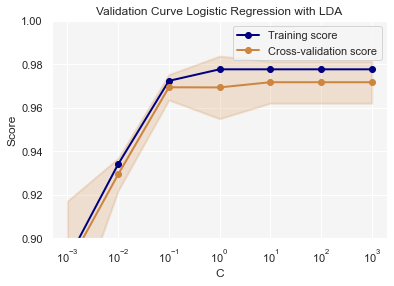

[0.88683473 0.9292437  0.96932773 0.96927171 0.97165266 0.97165266
 0.97165266]


In [43]:
params = {
    'classifier': LogisticRegression(class_weight={1:1.4}),
    'param_name':'C',
    'param_range':[0.001,0.01,0.1,1,10,100,1000],
    'name_classifier':'Logistic Regression with LDA'
}

plot_validation_curve(X_train_val_svm, y_train_val, params, y_min=0.9, y_max=1.0)

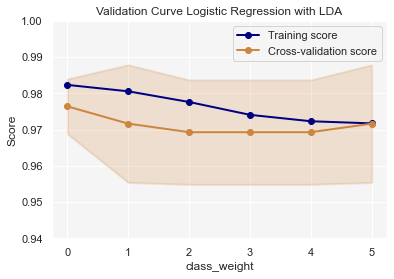

[0.97638655 0.97162465 0.96927171 0.96927171 0.96927171 0.97162465]


In [44]:
params = {
    'classifier': LogisticRegression(C=1),
    'param_name':'class_weight',
    'param_range': [{1:1}, {1:1.2}, {1:1.4},{1:1.6},{1:1.8}, {1:2}],
    'name_classifier':'Logistic Regression with LDA'
}

plot_validation_curve(X_train_val_svm, y_train_val, params, y_min=0.94, y_max=1.0, log_scale=False)

Accuracy score: 0.9788732394366197

LR coefficient: 4.232810541895875 -0.7384292255534267

Precision Recall F_score MACRO: (0.9838709677419355, 0.9711538461538461, 0.9769517935400097, None)

Precision Recall F_score CLASS MALIGNANT: (1.0, 0.9423076923076923, 0.9702970297029703, None)


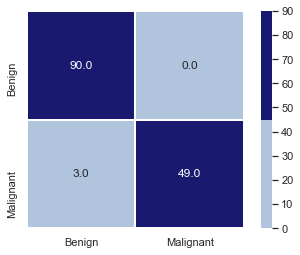

In [173]:
clf = LogisticRegression(C=1, class_weight={1:1.4})
clf.fit(X_train_val_logit, y_train_val)
y_pred = clf.predict(X_test_logit)

a =accuracy_score(y_test, y_pred)
print('Accuracy score:', a)
print('\nLR coefficient:', clf.coef_[0,0], clf.intercept_[0])

f = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('\nPrecision Recall F_score MACRO:',f)
f2 = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
print('\nPrecision Recall F_score CLASS MALIGNANT:',f2)


from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred, labels=(0, 1))
ax3 = sns.heatmap(c_matrix, linewidths =1, annot=True, fmt='.1f', square = True, cmap=['lightsteelblue', 'midnightblue'], 
                  xticklabels = ('Benign', 'Malignant'), yticklabels=('Benign','Malignant'))

In [174]:
y_pred_prob = clf.predict_proba(X_test_logit)
print(y_pred_prob[y_pred != y_test], '\n\n', y_test[y_pred != y_test])

[[0.86231038 0.13768962]
 [0.81739478 0.18260522]
 [0.86492398 0.13507602]] 

 [1 1 1]


In [175]:
y_pred_prob = clf.predict_proba(X_test_logit)
print(y_pred_prob[y_pred != y_test])

[[0.86231038 0.13768962]
 [0.81739478 0.18260522]
 [0.86492398 0.13507602]]


Text(0, 0.5, 'Response')

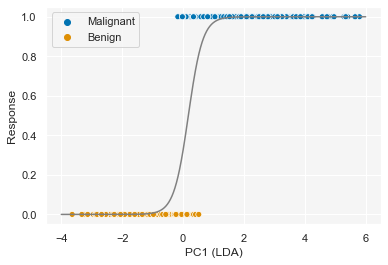

In [176]:
x = np.linspace(-4, 6, 1000)
import math
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y = sigmoid(x * clf.coef_ + clf.intercept_).ravel()


fig, ax = plt.subplots()
ax = sns.lineplot(x, y, color='gray')
ax = sns.scatterplot(df_LDA[0], final_labels, hue = [(lambda x: 'Benign' if x==0 else 'Malignant')(x) for x in final_labels], 
                legend='full')
ax.set_xlabel('PC1 (LDA)')
ax.set_ylabel('Response')

In [177]:
scaler = MinMaxScaler((0,12))
#print(X_train_val_logit)
score_train = scaler.fit_transform(X_train_val_logit)
score_test = scaler.transform(X_test_logit)

score_test[score_test>np.max(score_train)]=10
score_test[score_test<np.min(score_train)]=0

Accuracy score: 0.9788732394366197

LR coefficient: 3.716787379492287 -18.658612194631978

Precision Recall F_score MACRO: (0.9838709677419355, 0.9711538461538461, 0.9769517935400097, None)

Precision Recall F_score CLASS MALIGNANT: (1.0, 0.9423076923076923, 0.9702970297029703, None)


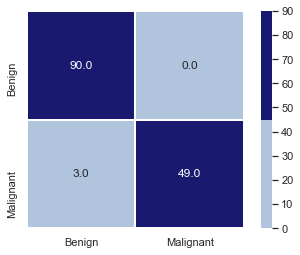

In [178]:
clf = LogisticRegression(C=1, class_weight={1:1.4})
clf.fit(score_train, y_train_val)
y_pred = clf.predict(score_test)

a = accuracy_score(y_test, y_pred)
print('Accuracy score:', a)
print('\nLR coefficient:', clf.coef_[0,0], clf.intercept_[0])

f = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('\nPrecision Recall F_score MACRO:',f)
f2 = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
print('\nPrecision Recall F_score CLASS MALIGNANT:',f2)


from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred, labels=(0, 1))
ax3 = sns.heatmap(c_matrix, linewidths =1, annot=True, fmt='.1f', square = True, cmap=['lightsteelblue', 'midnightblue'], 
                  xticklabels = ('Benign', 'Malignant'), yticklabels=('Benign','Malignant'))

In [179]:
y_pred_prob = clf.predict_proba(X_test_logit)
#print(y_pred_prob[y_test==1], '\n\n', y_test[y_pred != y_test])

In [180]:
print(clf.intercept_)

[-18.65861219]


[0.48133985]


Text(0, 0.5, 'Response')

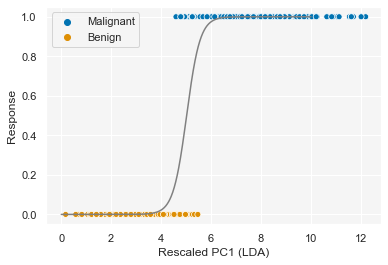

In [182]:
x = np.linspace(0, 10, 1000)
import math
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y = sigmoid(x * clf.coef_ + clf.intercept_).ravel()


fig, ax = plt.subplots()
ax = sns.lineplot(x, y, color='gray')
ax = sns.scatterplot(scaler.transform(df_LDA)[0], final_labels, hue = [(lambda x: 'Benign' if x==0 else 'Malignant')(x) for x in final_labels], 
                legend='full')

print(sigmoid(5 * clf.coef_ + clf.intercept_).ravel())
ax.set_xlabel('Rescaled PC1 (LDA)')
ax.set_ylabel('Response')